In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [ ]:
from mdp import MDPEnv, is_valid
from tqdm.contrib.concurrent import process_map
from tqdm import tqdm
import pickle
import gzip
from functools import cache
import numpy as np
from constants import MAP_SIZE, HAZARD_P, SLIP_P, MYOPIC, SEEDS
from helpers import batchl, flat

In [ ]:
def curr(student, teacher, train, seed):
    test = 1000
    bs = 32
    
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    model = tf.keras.models.load_model(f'/storage1/fs1/chien-ju.ho/Active/gym/models/myopic_{student}.keras')
    
    
    data = np.load(f'/storage1/fs1/chien-ju.ho/Active/gym/data/test/myopic_{teacher}.npz')
    x, y = data['x'], data['y']
    
    rng = np.random.default_rng(seed)
    
    start = rng.integers(15)
    x, y = x[start::15], y[start::15]
    
    perm = rng.permutation(len(x))
    x, y = x[perm], y[perm]
        
    model.fit(x[:train*bs], y[:train*bs], batch_size=bs, verbose=0)
    
    all_results = []
    
    for si, state in enumerate(x[-test:]):
        # print(f'{si}/{test}', end='\r')
        env = MDPEnv(map_size=MAP_SIZE, hazard_p=0.3, slip_p=0.4)
        env.reset(state)

        agents = []
        grids = []
        states = []
        target, hazards, rand = env.state['target'], env.state['hazards'], env.state['rand']
        hazard_grid = env.get_grid()[2]
        for i in range(MAP_SIZE):
            for j in range(MAP_SIZE):
                if (i,j) == target or (i,j) in hazards:
                    continue
                if not is_valid(hazard_grid, (i,j), target):
                    continue
                state = ((i,j), target, hazards, rand)
                env.reset(state)
                agents.append((i,j))
                grids.append(env.get_grid())
                states.append(state)

        actions = model.predict(np.array(grids)).argmax(axis=1)
        trans = dict(zip(agents, actions))

        visited = {}

        values = np.zeros((MAP_SIZE,MAP_SIZE))

        @cache
        def next_agents(agent):
            env.reset(state)
            env.state['agent'] = agent
            action = trans[agent]
            probs, next_agents = env.next_agents(action)
            res = []
            for prob, next_agent in zip(probs, next_agents):
                env.reset(state)
                env.state['agent'] = agent
                _, reward, terminated, truncated, _ = env.step(next_agent=next_agent)
                res.append((prob, next_agent, reward))
            return res

        for vi in range(100):
            next_values = np.zeros_like(values)
            for i, j in agents:
                for prob, (i2,j2), reward in next_agents((i,j)):
                    # print(prob, (i,j), (i2,j2), reward)
                    next_values[i][j] += prob * (values[i2,j2] + reward)
            values = next_values

        all_rewards = []
        for (i,j) in agents:
            all_rewards.append(values[i,j])
            
        all_results.append(np.mean(all_rewards))
        
    with open('output/res.txt', 'a') as f:
        print(f'{student},{teacher},{train},{test},{seed},{np.mean(all_results)}', file=f)

    return np.mean(all_results)

In [ ]:
%%time
iterables = []
for teacher in range(1,8):
    for train in [10, 100, 1000]:
        for seed in range(1):
            iterables.append((1,teacher,train,seed))
res = process_map(curr, *zip(*iterables))

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns

In [106]:
names = ['student', 'teacher', 'train', 'test', 'seed', 'res']
df = pd.read_csv('output/res8_1e-4.txt', names=names)
# df.groupby(['student','train']).res.agg(['mean','std','size'])

In [112]:
df[df.student==2]

,student,teacher,train,test,seed,res
39555,2,1,0,1000,1,2.441047
39562,2,1,0,1000,0,2.548997
39578,2,1,0,1000,51,2.416718
39579,2,1,0,1000,50,2.351458
39609,2,1,0,1000,2,2.443184
...,...,...,...,...,...,...
121275,2,19,80,1000,99,2.490382
121276,2,20,20,1000,99,2.376204
121277,2,20,40,1000,99,2.419074
121278,2,20,80,1000,99,2.464420


In [107]:
pd.set_option('display.max_rows', 200)

In [108]:
names = ['student', 'teacher', 'train', 'test', 'seed', 'res']
df = pd.read_csv('output/res8.txt', names=names)

/tmp/301921.tmpdir/ipykernel_112440/2240048410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['train'] = df2['train'].astype(str)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprec

<Axes: xlabel='teacher', ylabel='res'>

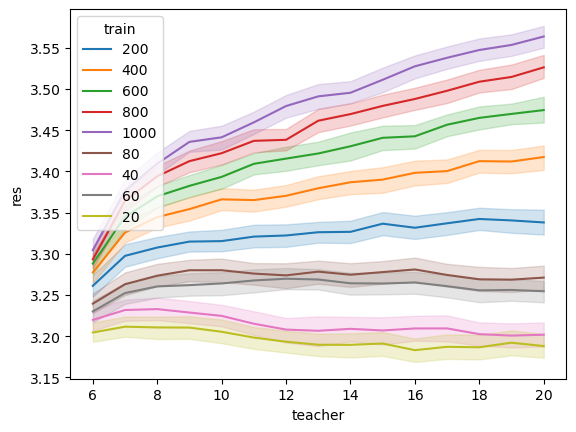

In [113]:
df2 = df[(df.student==5) & (df.train.isin([20, 40, 60, 80, 100, 200, 300, 400, 600, 800, 1000]))]
df2['train'] = df2['train'].astype(str)
sns.lineplot(data=df2, x='teacher',y='res', hue='train')

In [98]:
df2 = df[df.train==0].groupby(['student','train','teacher']).res.agg(['mean','std','size'])
df2['sem'] = df2['std'] / np.sqrt(df2['size'])
df2[['mean','sem','size']]

,,,mean,sem,size
student,train,teacher,,,
1,0,1,1.647731,0.003458,200
2,0,1,2.424828,0.004025,200
3,0,1,2.772922,0.004513,200
4,0,1,3.031003,0.004335,200
5,0,1,3.209092,0.004541,200
6,0,1,3.345305,0.004430,200
7,0,1,3.507655,0.004521,200
8,0,1,3.684734,0.004889,200
9,0,1,3.770354,0.004896,200


In [63]:
import tensorflow as tf

In [65]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(4, 8, 8)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(4)
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [66]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [67]:
model = tf.keras.models.load_model(f'/storage1/fs1/chien-ju.ho/Active/gym/models{8}/myopic_{6}.keras')

In [68]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [70]:
from tensorflow.keras import backend as K

In [72]:
K.set_value(model.optimizer.learning_rate, 0.0001)
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 1e-04,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [5]:
x.shape

(74206, 4, 8, 8)

In [7]:
rng = np.random.default_rng(0)

In [8]:
rng.choice(100, size=2, replace=False)

array([84, 63])